In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, roc_curve, roc_auc_score

# from imblearn.over_sampling import SMOTE

from xgboost import XGBClassifier


In [2]:
df = pd.read_csv(r"C:\Users\admin\Downloads\archive (1)\PS_20174392719_1491204439457_log.csv")
df.info()
df.head()
df.duplicated().sum()
df.isnull().sum()
df['isFraud'].value_counts(normalize=True)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


isFraud
0    0.998709
1    0.001291
Name: proportion, dtype: float64

<Axes: title={'center': 'Fraud vs Non-Fraud'}, xlabel='isFraud', ylabel='count'>

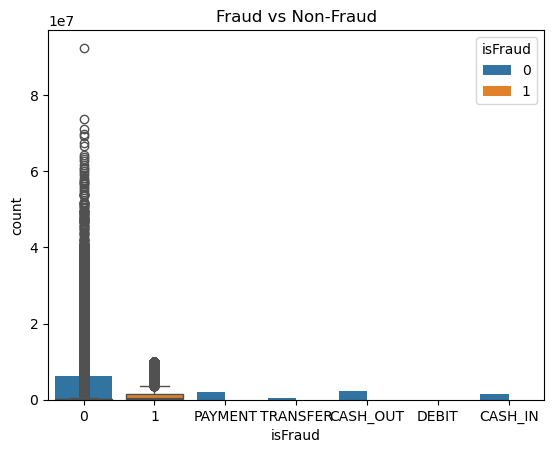

In [3]:
sns.countplot(x='isFraud', data=df)
plt.title('Fraud vs Non-Fraud')

sns.boxplot(x='isFraud', y='amount', data=df)
sns.countplot(x='type', hue='isFraud', data=df)


In [4]:
df.drop(columns=['nameOrig', 'nameDest'], inplace=True)


In [5]:
# Extract hour of the day
df['hour'] = df['step'] % 24

# Bin hour into time-of-day categories
def time_bin(hour):
    if 0 <= hour < 6:
        return 'Night'
    elif 6 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 18:
        return 'Afternoon'
    else:
        return 'Evening'

df['time_bin'] = df['hour'].apply(time_bin)

# Extract day of the week
df['day'] = df['step'] // 24
df['day_of_week'] = df['day'] % 7  # 0 (Mon) to 6 (Sun)
day_map = {0: 'Mon', 1: 'Tue', 2: 'Wed', 3: 'Thu', 4: 'Fri', 5: 'Sat', 6: 'Sun'}
df['day_name'] = df['day_of_week'].map(day_map)

# One-hot encode time_bin and day_name (nominal)
df = pd.get_dummies(df, columns=['time_bin', 'day_name'], drop_first=False)


In [6]:
df.columns

Index(['step', 'type', 'amount', 'oldbalanceOrg', 'newbalanceOrig',
       'oldbalanceDest', 'newbalanceDest', 'isFraud', 'isFlaggedFraud', 'hour',
       'day', 'day_of_week', 'time_bin_Afternoon', 'time_bin_Evening',
       'time_bin_Morning', 'time_bin_Night', 'day_name_Fri', 'day_name_Mon',
       'day_name_Sat', 'day_name_Sun', 'day_name_Thu', 'day_name_Tue',
       'day_name_Wed'],
      dtype='object')

In [7]:
df['amount_log'] = np.log1p(df['amount'])
df.drop(columns='amount', inplace=True)


In [8]:
df = pd.get_dummies(df, columns=['type'], drop_first=False)


In [9]:
scaler = StandardScaler()
num_cols = df.select_dtypes(include=np.number).columns.drop('isFraud')
df[num_cols] = scaler.fit_transform(df[num_cols])


In [10]:
# Sort the dataset by the 'step' column to ensure a chronological split
df_sorted = df.sort_values(by='step').reset_index(drop=True)

# Separate features (X) and target (y)
X = df_sorted.drop(columns=['isFraud'])
y = df_sorted['isFraud']

# Define the split index (80% for training, 20% for testing)
split_index = int(0.8 * len(df_sorted))

# Split the data into training and testing sets
X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]

print("Training set shape:", X_train.shape)
print("Testing set shape:", X_test.shape)


Training set shape: (5090096, 26)
Testing set shape: (1272524, 26)


In [11]:
!pip install -q xgboost


In [13]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from collections import Counter



# Step 0: Inspect original class distribution
print("Original:", Counter(y_train))

# Step 1: SMOTE — oversample minority (fraud) to 5× original
n_fraud = Counter(y_train)[1]
target_fraud = n_fraud * 5
smote = SMOTE(sampling_strategy={1: target_fraud}, random_state=42)

# Step 2: Undersample majority (non-fraud) to exactly 56,000
under = RandomUnderSampler(sampling_strategy={0: 56000}, random_state=42)

# Step 3: Pipeline
pipeline = Pipeline([
    ('smote', smote),
    ('under', under)
])

# Step 4: Resample
X_resampled, y_resampled = pipeline.fit_resample(X_train, y_train)

# Step 5: Check result
print("Resampled:", Counter(y_resampled))


Original: Counter({0: 5086137, 1: 3959})
Resampled: Counter({0: 56000, 1: 19795})


In [14]:
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import average_precision_score, classification_report

# Configure XGBClassifier for GPU usage
# We remove scale_pos_weight because we have already resampled the data.
# 'device="cuda"' is the modern way to specify GPU usage with tree_method='hist'.
xgb_gpu = XGBClassifier(
    eval_metric='aucpr',
    tree_method='hist',
    device='cuda', # Use 'device' instead of 'predictor' for training
    verbosity=1,
    random_state=42
)

# The parameter distribution remains the same
param_dist = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.7, 0.9, 1.0],
    'colsample_bytree': [0.7, 0.9, 1.0],
    'gamma': [0, 1, 3],
    'min_child_weight': [1, 3, 5]
}

search_gpu = RandomizedSearchCV(
    estimator=xgb_gpu,
    param_distributions=param_dist,
    n_iter=25,
    scoring='average_precision',
    cv=3,
    verbose=2,
    n_jobs=-1,
    random_state=42
)

search_gpu.fit(X_resampled, y_resampled)

# Store the best model from the search
best_model = search_gpu.best_estimator_
print("Best Parameters found by RandomizedSearchCV:")
print(search_gpu.best_params_)

Fitting 3 folds for each of 25 candidates, totalling 75 fits


c:\Users\admin\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [14:09:07] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\context.cc:49: No visible GPU is found, setting device to CPU.
  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\admin\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [14:09:07] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\context.cc:203: XGBoost is not compiled with CUDA support.
  bst.update(dtrain, iteration=i, fobj=obj)


Best Parameters found by RandomizedSearchCV:
{'subsample': 0.9, 'n_estimators': 300, 'min_child_weight': 5, 'max_depth': 10, 'learning_rate': 0.1, 'gamma': 0, 'colsample_bytree': 0.9}


No Hyper Parameter tuning

Precision-Recall AUC on Test Set: 0.9651



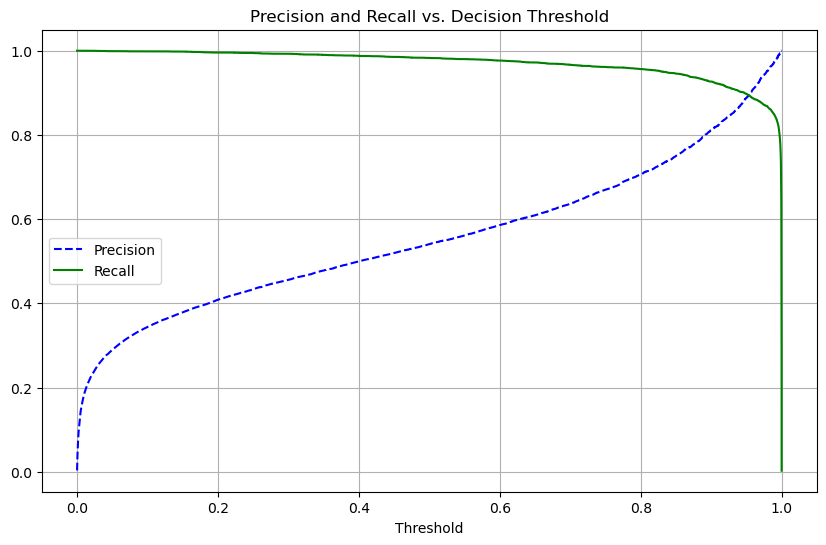

Chosen Threshold (for Recall >= 0.95): 0.0000

Classification Report on Test Set (Using Optimal Threshold):


c:\Users\admin\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\admin\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\admin\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00   1268270
           1       0.00      1.00      0.01      4254

    accuracy                           0.00   1272524
   macro avg       0.00      0.50      0.00   1272524
weighted avg       0.00      0.00      0.00   1272524



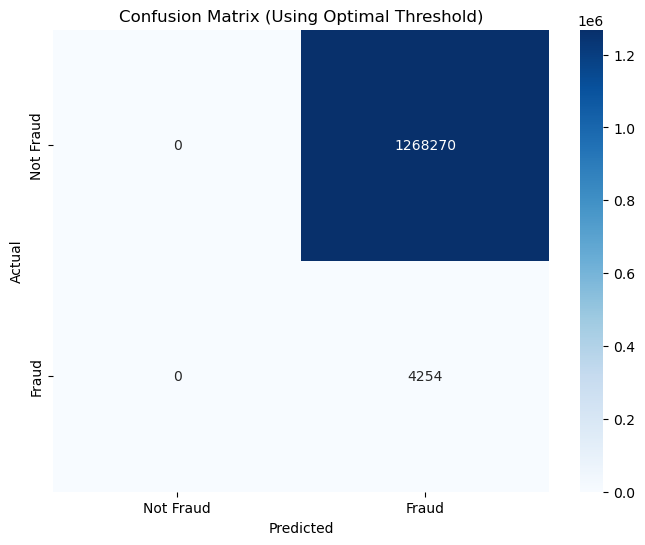


Detailed Metrics from Confusion Matrix:
True Positives (TP): 4254 (Correctly identified fraud)
True Negatives (TN): 0 (Correctly identified non-fraud)
False Positives (FP): 1268270 (Non-fraud incorrectly marked as fraud)
False Negatives (FN): 0 (Fraud missed by the model)
Total Errors (FP + FN): 1268270


In [15]:
from sklearn.metrics import precision_recall_curve, classification_report, confusion_matrix, average_precision_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# First, get the best model from the search
best_model = search_gpu.best_estimator_

# Predict probabilities on the UNSEEN TEST SET
y_probs_test = best_model.predict_proba(X_test)[:, 1]

# 1. Calculate and Print PR AUC on the test data
pr_auc = average_precision_score(y_test, y_probs_test)
print(f"Precision-Recall AUC on Test Set: {pr_auc:.4f}\n")

# 2. Plot Precision and Recall against the Threshold to find an optimal value
precision, recall, thresholds = precision_recall_curve(y_test, y_probs_test)

plt.figure(figsize=(10, 6))
plt.plot(thresholds, precision[:-1], "b--", label="Precision")
plt.plot(thresholds, recall[:-1], "g-", label="Recall")
plt.xlabel("Threshold")
plt.title("Precision and Recall vs. Decision Threshold")
plt.legend()
plt.grid()
plt.show()


# 3. Choose a new threshold to balance precision and recall.
# For fraud detection, you might want high recall (e.g., > 0.95)
# to catch as many fraudulent transactions as possible.
try:
    # Find the first threshold that gives us at least 0.95 recall
    optimal_threshold_index = np.min(np.where(recall >= 0.95))
    optimal_threshold = thresholds[optimal_threshold_index]
except (ValueError, IndexError):
    # Fallback if no threshold meets the criteria, use a reasonable default
    optimal_threshold = 0.4

print(f"Chosen Threshold (for Recall >= 0.95): {optimal_threshold:.4f}\n")


# 4. Apply the new threshold and generate the final classification report
y_pred_optimal = (y_probs_test >= optimal_threshold).astype(int)

print("Classification Report on Test Set (Using Optimal Threshold):")
print(classification_report(y_test, y_pred_optimal))


# 5. Show the new Confusion Matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred_optimal)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Fraud', 'Fraud'], yticklabels=['Not Fraud', 'Fraud'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Using Optimal Threshold)')
plt.show()

# 6. Detailed Error Analysis
tn, fp, fn, tp = cm.ravel()
print(f"\nDetailed Metrics from Confusion Matrix:")
print(f"True Positives (TP): {tp} (Correctly identified fraud)")
print(f"True Negatives (TN): {tn} (Correctly identified non-fraud)")
print(f"False Positives (FP): {fp} (Non-fraud incorrectly marked as fraud)")
print(f"False Negatives (FN): {fn} (Fraud missed by the model)")
print(f"Total Errors (FP + FN): {fp + fn}")

In [17]:
pip install shap

   ---------------------------------------- 0.0/545.1 kB ? eta -:--:--
   ---------------------------------------- 545.1/545.1 kB 4.7 MB/s eta 0:00:00

   -------------------- ------------------- 1/2 [shap]
   -------------------- ------------------- 1/2 [shap]
   -------------------- ------------------- 1/2 [shap]
   -------------------- ------------------- 1/2 [shap]
   -------------------- ------------------- 1/2 [shap]
   -------------------- ------------------- 1/2 [shap]
   -------------------- ------------------- 1/2 [shap]
   -------------------- ------------------- 1/2 [shap]
   ---------------------------------------- 2/2 [shap]

Note: you may need to restart the kernel to use updated packages.


In [18]:
import shap

# It's computationally expensive to run SHAP on the entire test set.
# We will use a smaller, random sample for faster analysis.
X_test_sample = X_test.sample(n=1000, random_state=42)

# Create a TreeExplainer using the trained model
explainer = shap.Explainer(best_model)

# Compute SHAP values for the test set sample
shap_values = explainer(X_test_sample)

SHAP Beeswarm Plot (Feature Importance)


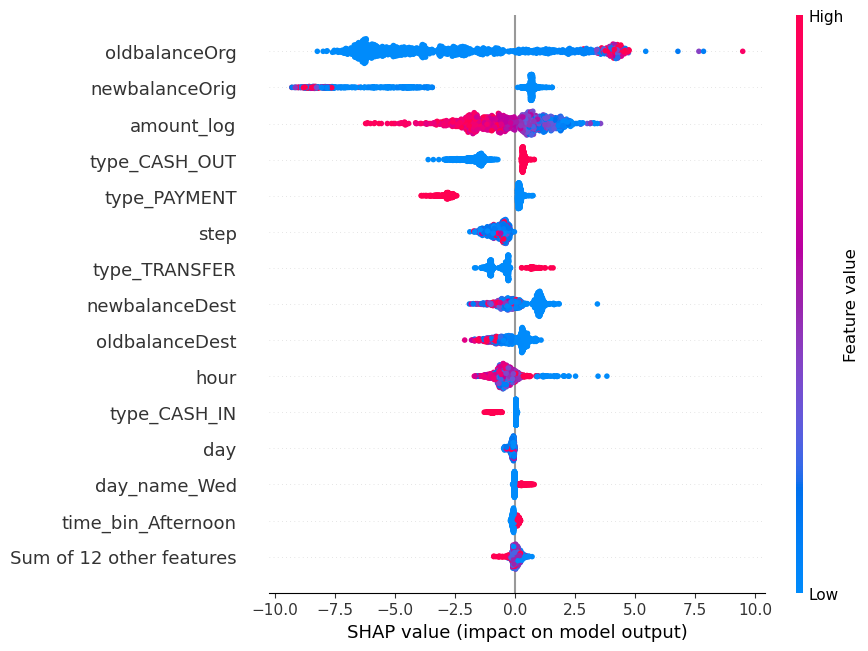

In [19]:
# Visualize feature importance with a beeswarm plot
# This plot shows the impact of each feature on the model's output
print("SHAP Beeswarm Plot (Feature Importance)")
shap.plots.beeswarm(shap_values, max_display=15)


SHAP Waterfall Plot (Explaining a Single Prediction)


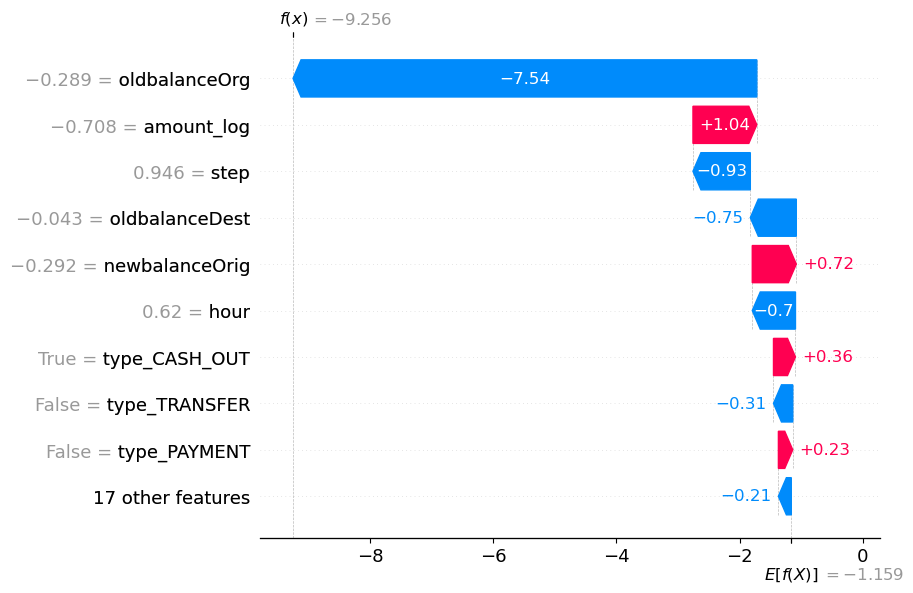

In [20]:
# Explain a single prediction with a waterfall plot
# This shows how each feature contributed to the prediction for the first instance in our sample
print("\nSHAP Waterfall Plot (Explaining a Single Prediction)")
shap.plots.waterfall(shap_values[0])